In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import tensorflow as tf

import ipdb
import os
import bda_utils

# Load data

In [2]:
Xs, Xt = bda_utils.load_data(if_weekday=1, if_interdet=1)
Xs = Xs[:,8:9]
Xt = Xt[:,8:9]
Xs, Xs_min, Xs_max = bda_utils.normalize2D(Xs)
Xt, Xt_min, Xt_max = bda_utils.normalize2D(Xt)

In [3]:
label_seq_len = 7
# batch_size = full batch
seq_len = 12
reduced_dim = 4
inp_dim = min(Xs.shape[1], Xt.shape[1])
label_dim = min(Xs.shape[1], Xt.shape[1])
hid_dim = 3
layers = 1
lamb = 2
MU = 0.7
bda_dim = label_seq_len-4
kernel_type = 'linear'

hyper = {
    'inp_dim':inp_dim,
    'label_dim':label_dim,
    'label_seq_len':label_seq_len,
    'seq_len':seq_len,
    'reduced_dim':reduced_dim,
    'hid_dim':hid_dim,
    'layers':layers,
    'lamb':lamb,
    'MU': MU,
    'bda_dim':bda_dim,
    'kernel_type':kernel_type}

hyper = pd.DataFrame(hyper, index=['Values'])
hyper

,inp_dim,label_dim,label_seq_len,seq_len,reduced_dim,hid_dim,layers,lamb,MU,bda_dim,kernel_type
Values,1,1,7,12,4,3,1,2,0.7,3,linear


In [4]:
Xs = Xs[:96, :]

# [sample size, seq_len, inp_dim (dets)], [sample size, label_seq_len, inp_dim (dets)]
Xs_3d, Ys_3d = bda_utils.sliding_window(Xs, Xs, seq_len, label_seq_len)  
Xt_3d, Yt_3d = bda_utils.sliding_window(Xt, Xt, seq_len, label_seq_len)
Ys_3d = Ys_3d[:, label_seq_len-1:, :]
Yt_3d = Yt_3d[:, label_seq_len-1:, :]
print(Xs_3d.shape)
print(Ys_3d.shape)
print(Xt_3d.shape)
print(Yt_3d.shape)

(78, 12, 1)
(78, 1, 1)
(462, 12, 1)
(462, 1, 1)


In [5]:

Xs_train_3d = []
Ys_train_3d = []
Xt_valid_3d = []
Xt_train_3d = []
Yt_valid_3d = []
Yt_train_3d = []

for i in range(Xs_3d.shape[2]):

#     bda = BDA(kernel_type='linear', dim=seq_len-reduced_dim, lamb=lamb, mu=0.6, gamma=1, T=1)  # T is iteration time
#     Xs_new, Xt_new, A = bda.fit(
#         Xs_3d[:, :, i], bda_utils.get_class(Ys_3d[:, :, i]), Xt_3d[:, :, i], bda_utils.get_class(Yt_3d[:, :, i])
#     )  # input shape: ns, n_feature | ns, n_label_feature
    Xs_new = Xs_3d[:, :, 0]
    Xt_new = Xt_3d[:, :, 0]

    day_train_t = 1
    Xs_train = Xs_new.copy()
    Ys_train = Ys_3d[:, :, i]
    Xt_valid = Xt_new.copy()[int(Xs_3d.shape[0]):, :]
    Xt_train = Xt_new.copy()[:int(Xs_3d.shape[0]), :]
    Yt_valid = Yt_3d[:, :, i].copy()[int(Xs_3d.shape[0]):, :]
    Yt_train = Yt_3d[:, :, i].copy()[:int(Xs_3d.shape[0]), :]
    
    Xs_train_3d.append(Xs_train)
    Ys_train_3d.append(Ys_train)
    Xt_valid_3d.append(Xt_valid)
    Xt_train_3d.append(Xt_train)
    Yt_valid_3d.append(Yt_valid)
    Yt_train_3d.append(Yt_train)


Xs_train_3d = np.array(Xs_train_3d)
Ys_train_3d = np.array(Ys_train_3d)
Xt_valid_3d = np.array(Xt_valid_3d)
Xt_train_3d = np.array(Xt_train_3d)
Yt_valid_3d = np.array(Yt_valid_3d)
Yt_train_3d = np.array(Yt_train_3d)

# bda_utils.save_np(Xs_train_3d, './outputs/BDA/Xs_new_%i.csv'%(bda_utils.get_num()-14/6))
# bda_utils.save_np(Ys_train_3d, './outputs/BDA/Xt_new_%i.csv'%(bda_utils.get_num()-14/6))
# bda_utils.save_np(Xt_valid_3d, './outputs/BDA/Xs_new_%i.csv'%(bda_utils.get_num()-14/6))
# bda_utils.save_np(Xt_train_3d, './outputs/BDA/Xt_new_%i.csv'%(bda_utils.get_num()-14/6))
# bda_utils.save_np(Yt_valid_3d, './outputs/BDA/Xs_new_%i.csv'%(bda_utils.get_num()-14/6))
# bda_utils.save_np(Yt_train_3d, './outputs/BDA/Xt_new_%i.csv'%(bda_utils.get_num()-14/6))


In [6]:
print(Xs_train.shape)
print(Ys_train.shape)
print(Xt_valid.shape)
print(Xt_train.shape)
print(Yt_valid.shape)
print(Yt_train.shape)

(78, 12)
(78, 1)
(384, 12)
(78, 12)
(384, 1)
(78, 1)


# LSTM

In [44]:
model = keras.models.Sequential()
# out shape: [window_size, hid_dim]
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.LSTM(units=hid_dim, return_sequences=True))
model.add(keras.layers.LSTM(units=hid_dim, return_sequences=True))
model.add(keras.layers.LSTM(units=hid_dim, return_sequences=False))

model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(1, activation='relu'))

# Training on target data

In [45]:
model.compile(loss='mse', optimizer='adam')
history = model.fit(
    Xt_train[:, :, np.newaxis], Yt_train[:, :, np.newaxis],
    epochs=500, batch_size=128, validation_data=(Xt_valid[:, :, np.newaxis], Yt_valid[:, :, np.newaxis]),
    verbose=2, shuffle=True
)


Epoch 1/500
1/1 - 5s - loss: 0.2042 - val_loss: 0.2040
Epoch 2/500
1/1 - 0s - loss: 0.1999 - val_loss: 0.1981
Epoch 3/500
1/1 - 0s - loss: 0.1957 - val_loss: 0.1924
Epoch 4/500
1/1 - 0s - loss: 0.1917 - val_loss: 0.1868
Epoch 5/500
1/1 - 0s - loss: 0.1877 - val_loss: 0.1813
Epoch 6/500
1/1 - 0s - loss: 0.1839 - val_loss: 0.1759
Epoch 7/500
1/1 - 0s - loss: 0.1802 - val_loss: 0.1707
Epoch 8/500
1/1 - 0s - loss: 0.1766 - val_loss: 0.1656
Epoch 9/500
1/1 - 0s - loss: 0.1730 - val_loss: 0.1605
Epoch 10/500
1/1 - 0s - loss: 0.1696 - val_loss: 0.1557
Epoch 11/500
1/1 - 0s - loss: 0.1663 - val_loss: 0.1509
Epoch 12/500
1/1 - 0s - loss: 0.1631 - val_loss: 0.1464
Epoch 13/500
1/1 - 0s - loss: 0.1601 - val_loss: 0.1419
Epoch 14/500
1/1 - 0s - loss: 0.1571 - val_loss: 0.1377
Epoch 15/500
1/1 - 0s - loss: 0.1543 - val_loss: 0.1336
Epoch 16/500
1/1 - 0s - loss: 0.1516 - val_loss: 0.1297
Epoch 17/500
1/1 - 0s - loss: 0.1490 - val_loss: 0.1259
Epoch 18/500
1/1 - 0s - loss: 0.1463 - val_loss: 0.1224
E

Epoch 147/500
1/1 - 0s - loss: 0.0987 - val_loss: 0.0819
Epoch 148/500
1/1 - 0s - loss: 0.0987 - val_loss: 0.0822
Epoch 149/500
1/1 - 0s - loss: 0.0986 - val_loss: 0.0825
Epoch 150/500
1/1 - 0s - loss: 0.0985 - val_loss: 0.0828
Epoch 151/500
1/1 - 0s - loss: 0.0985 - val_loss: 0.0831
Epoch 152/500
1/1 - 0s - loss: 0.0984 - val_loss: 0.0834
Epoch 153/500
1/1 - 0s - loss: 0.0984 - val_loss: 0.0838
Epoch 154/500
1/1 - 0s - loss: 0.0983 - val_loss: 0.0841
Epoch 155/500
1/1 - 0s - loss: 0.0982 - val_loss: 0.0845
Epoch 156/500
1/1 - 0s - loss: 0.0982 - val_loss: 0.0848
Epoch 157/500
1/1 - 0s - loss: 0.0981 - val_loss: 0.0852
Epoch 158/500
1/1 - 0s - loss: 0.0980 - val_loss: 0.0856
Epoch 159/500
1/1 - 0s - loss: 0.0980 - val_loss: 0.0860
Epoch 160/500
1/1 - 0s - loss: 0.0979 - val_loss: 0.0863
Epoch 161/500
1/1 - 0s - loss: 0.0979 - val_loss: 0.0867
Epoch 162/500
1/1 - 0s - loss: 0.0978 - val_loss: 0.0872
Epoch 163/500
1/1 - 0s - loss: 0.0977 - val_loss: 0.0876
Epoch 164/500
1/1 - 0s - loss: 

Epoch 291/500
1/1 - 0s - loss: 0.0738 - val_loss: 0.0708
Epoch 292/500
1/1 - 0s - loss: 0.0737 - val_loss: 0.0700
Epoch 293/500
1/1 - 0s - loss: 0.0735 - val_loss: 0.0691
Epoch 294/500
1/1 - 0s - loss: 0.0734 - val_loss: 0.0683
Epoch 295/500
1/1 - 0s - loss: 0.0734 - val_loss: 0.0676
Epoch 296/500
1/1 - 0s - loss: 0.0733 - val_loss: 0.0669
Epoch 297/500
1/1 - 0s - loss: 0.0732 - val_loss: 0.0662
Epoch 298/500
1/1 - 0s - loss: 0.0729 - val_loss: 0.0656
Epoch 299/500
1/1 - 0s - loss: 0.0720 - val_loss: 0.0650
Epoch 300/500
1/1 - 0s - loss: 0.0715 - val_loss: 0.0643
Epoch 301/500
1/1 - 0s - loss: 0.0714 - val_loss: 0.0634
Epoch 302/500
1/1 - 0s - loss: 0.0713 - val_loss: 0.0622
Epoch 303/500
1/1 - 0s - loss: 0.0708 - val_loss: 0.0609
Epoch 304/500
1/1 - 0s - loss: 0.0702 - val_loss: 0.0597
Epoch 305/500
1/1 - 0s - loss: 0.0699 - val_loss: 0.0588
Epoch 306/500
1/1 - 0s - loss: 0.0699 - val_loss: 0.0582
Epoch 307/500
1/1 - 0s - loss: 0.0697 - val_loss: 0.0580
Epoch 308/500
1/1 - 0s - loss: 

Epoch 435/500
1/1 - 0s - loss: 0.0059 - val_loss: 0.0501
Epoch 436/500
1/1 - 0s - loss: 0.0059 - val_loss: 0.0497
Epoch 437/500
1/1 - 0s - loss: 0.0059 - val_loss: 0.0493
Epoch 438/500
1/1 - 0s - loss: 0.0059 - val_loss: 0.0489
Epoch 439/500
1/1 - 0s - loss: 0.0059 - val_loss: 0.0485
Epoch 440/500
1/1 - 0s - loss: 0.0059 - val_loss: 0.0481
Epoch 441/500
1/1 - 0s - loss: 0.0058 - val_loss: 0.0477
Epoch 442/500
1/1 - 0s - loss: 0.0058 - val_loss: 0.0473
Epoch 443/500
1/1 - 0s - loss: 0.0058 - val_loss: 0.0469
Epoch 444/500
1/1 - 0s - loss: 0.0058 - val_loss: 0.0465
Epoch 445/500
1/1 - 0s - loss: 0.0058 - val_loss: 0.0461
Epoch 446/500
1/1 - 0s - loss: 0.0058 - val_loss: 0.0458
Epoch 447/500
1/1 - 0s - loss: 0.0057 - val_loss: 0.0454
Epoch 448/500
1/1 - 0s - loss: 0.0057 - val_loss: 0.0450
Epoch 449/500
1/1 - 0s - loss: 0.0057 - val_loss: 0.0446
Epoch 450/500
1/1 - 0s - loss: 0.0057 - val_loss: 0.0443
Epoch 451/500
1/1 - 0s - loss: 0.0057 - val_loss: 0.0440
Epoch 452/500
1/1 - 0s - loss: 

# Visualization

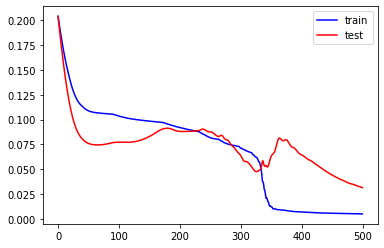

In [46]:
p1 = plt.plot(history.history['loss'], color='blue', label='train')
p2 = plt.plot(history.history['val_loss'], color='red',label='test')
plt.legend()

# Evaluation

In [47]:
g_t = Yt_valid.flatten()
pred = model.predict(Xt_valid[:, :, np.newaxis]).flatten()

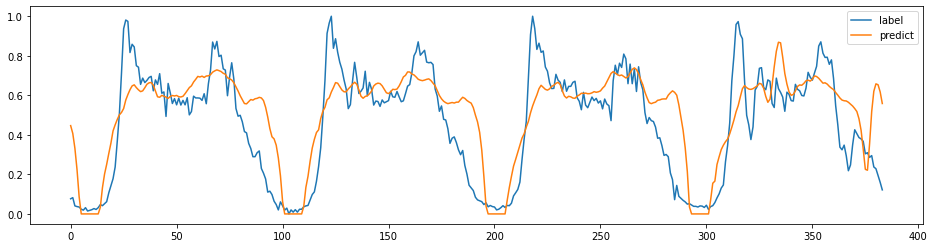

In [50]:
plt.figure(figsize=[16,4])
plt.plot(g_t, label='label')
plt.plot(pred, label='predict')
plt.legend()

bda_utils.save_np(g_t, './runs_base/base_data_plot/g_t_base_LSTM.csv')
bda_utils.save_np(pred, './runs_base/base_data_plot/pred_base_LSTM.csv')

In [51]:
print(bda_utils.nrmse_loss_func(pred, g_t, 0))
print(bda_utils.smape_loss_func(pred, g_t, 0))

0.19029039769738704
0.3724195462156863
